In [38]:
### we need to import the pandas and numpy (essential libraries)
import pandas as pd
import numpy as np
### Import data visualization packages 
import matplotlib.pyplot as plt 
import seaborn as sns 
import altair as alt 
### import preprocessing packages
from sklearn.model_selection import train_test_split ### needed to create training and testing datasets 
from sklearn.impute import SimpleImputer, KNNImputer ### need to impute the data 
from sklearn.preprocessing import StandardScaler, OneHotEncoder ### need to standarize and scale the data correctly 
from sklearn.compose import ColumnTransformer ### this is needed to create the pipeline 
from sklearn.pipeline import Pipeline ### this will create the pipeline 
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression

#### Create a random seed for reproducability

In [39]:
random_seed = 172193
np.random.seed(random_seed)

---

#### Load in the dataset

In [40]:
df = pd.read_excel('Employee_Data_Project.xlsx')
print(f'The Dataset shape is: {df.shape}')

The Dataset shape is: (4410, 18)


### looking at the data structure

In [41]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4410 entries, 0 to 4409
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Age                      4410 non-null   int64  
 1   Attrition                4410 non-null   object 
 2   BusinessTravel           4410 non-null   object 
 3   DistanceFromHome         4410 non-null   int64  
 4   Education                4410 non-null   int64  
 5   EmployeeID               4410 non-null   int64  
 6   Gender                   4410 non-null   object 
 7   JobLevel                 4410 non-null   int64  
 8   MaritalStatus            4410 non-null   object 
 9   Income                   4410 non-null   int64  
 10  NumCompaniesWorked       4391 non-null   float64
 11  StandardHours            4410 non-null   int64  
 12  TotalWorkingYears        4401 non-null   float64
 13  TrainingTimesLastYear    4410 non-null   int64  
 14  YearsAtCompany          

---

#### check the rows with nulls 

In [42]:
missing = df.isna().sum()
## to get the percentage missing (divide by the length of the dataframe)
missing_per = (missing / len(df)) *100

print(missing)
print(missing_per)

Age                         0
Attrition                   0
BusinessTravel              0
DistanceFromHome            0
Education                   0
EmployeeID                  0
Gender                      0
JobLevel                    0
MaritalStatus               0
Income                      0
NumCompaniesWorked         19
StandardHours               0
TotalWorkingYears           9
TrainingTimesLastYear       0
YearsAtCompany              0
YearsWithCurrManager        0
EnvironmentSatisfaction    25
JobSatisfaction            20
dtype: int64
Age                        0.000000
Attrition                  0.000000
BusinessTravel             0.000000
DistanceFromHome           0.000000
Education                  0.000000
EmployeeID                 0.000000
Gender                     0.000000
JobLevel                   0.000000
MaritalStatus              0.000000
Income                     0.000000
NumCompaniesWorked         0.430839
StandardHours              0.000000
TotalWorkingYea

---

In [43]:
df['StandardHours'].nunique()


1

#### since standard hours is all constant, will drop this column

---

In [44]:
df.columns

Index(['Age', 'Attrition', 'BusinessTravel', 'DistanceFromHome', 'Education',
       'EmployeeID', 'Gender', 'JobLevel', 'MaritalStatus', 'Income',
       'NumCompaniesWorked', 'StandardHours', 'TotalWorkingYears',
       'TrainingTimesLastYear', 'YearsAtCompany', 'YearsWithCurrManager',
       'EnvironmentSatisfaction', 'JobSatisfaction'],
      dtype='object')

In [45]:
target = 'Attrition'
drop = ['EmployeeID' , 'StandardHours']
num_vars = ['Age' , 'DistanceFromHome' , 'Income' , 'NumCompaniesWorked' , 'TotalWorkingYears' , 'TrainingTimesLastYear'
            , 'YearsAtCompany' , 'YearsWithCurrManager']
ordinal_vars = ['Education' , 'JobLevel' , 'EnvironmentSatisfaction' , 'JobSatisfaction']
nom_vars = ['Gender' , 'BusinessTravel' , 'MaritalStatus']


---

In [46]:
df['Attrition_lab'] = df['Attrition'].map({'Yes':1 , 'No' :0})


---

In [47]:
X = df[num_vars+ordinal_vars+nom_vars].copy()
y= df['Attrition_lab'].copy()

X_train , X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, stratify=y, random_state=random_seed)

---

#### Build Preprocessing Pipeline 


In [48]:
## need to transform the numeric columns, nominal and ordinal columns 
### KNN imputation for the numerical columns
numeric_imputation = Pipeline(steps = [(
    'imputer' , KNNImputer(n_neighbors=5 , weights='uniform')),
('scaler' , StandardScaler())])
### regarding the nominal variables , use onehotencoding and replace the nulls with the mode (most frequent)
nominal_imputation = Pipeline(steps=[(
'imputer' , SimpleImputer(strategy= 'most_frequent')),
('one_hot_encoder' , OneHotEncoder(handle_unknown= 'ignore' , sparse_output= False , drop = 'first'))])
### regarding the ordinal variables replace with the median 
ordinal_imputation = Pipeline(steps= [('imputer' , SimpleImputer(strategy='median'))])

In [49]:
pre_process = ColumnTransformer(transformers=[('numeric' , numeric_imputation , num_vars),
                                              ('ordinal' , ordinal_imputation, ordinal_vars),
                                              ('nominal' , nominal_imputation , nom_vars)])


In [50]:
X_train_processed = pre_process.fit_transform(X_train)  
X_test_processed = pre_process.transform(X_test)


In [51]:
feature_names = pre_process.get_feature_names_out()
feature_names

array(['numeric__Age', 'numeric__DistanceFromHome', 'numeric__Income',
       'numeric__NumCompaniesWorked', 'numeric__TotalWorkingYears',
       'numeric__TrainingTimesLastYear', 'numeric__YearsAtCompany',
       'numeric__YearsWithCurrManager', 'ordinal__Education',
       'ordinal__JobLevel', 'ordinal__EnvironmentSatisfaction',
       'ordinal__JobSatisfaction', 'nominal__Gender_Male',
       'nominal__BusinessTravel_Travel_Frequently',
       'nominal__BusinessTravel_Travel_Rarely',
       'nominal__MaritalStatus_Married', 'nominal__MaritalStatus_Single'],
      dtype=object)

In [52]:
X_train_processed_df = pd.DataFrame(X_train_processed, columns=feature_names)
X_test_processed_df = pd.DataFrame(X_test_processed, columns= feature_names)

X_train_processed_df

,numeric__Age,numeric__DistanceFromHome,numeric__Income,numeric__NumCompaniesWorked,numeric__TotalWorkingYears,numeric__TrainingTimesLastYear,numeric__YearsAtCompany,numeric__YearsWithCurrManager,ordinal__Education,ordinal__JobLevel,ordinal__EnvironmentSatisfaction,ordinal__JobSatisfaction,nominal__Gender_Male,nominal__BusinessTravel_Travel_Frequently,nominal__BusinessTravel_Travel_Rarely,nominal__MaritalStatus_Married,nominal__MaritalStatus_Single
0,-0.204878,-0.155259,-0.574737,-0.666602,-1.304028,-0.601912,-0.980175,-0.866629,4.0,3.0,4.0,4.0,0.0,0.0,1.0,1.0,0.0
1,1.009692,-0.892809,2.148524,2.148666,2.151124,0.960832,3.110955,1.365332,3.0,2.0,3.0,1.0,1.0,0.0,1.0,1.0,0.0
2,0.126368,1.319841,-0.962122,0.137760,1.127376,0.179460,1.801793,1.923322,4.0,2.0,2.0,3.0,0.0,0.0,1.0,1.0,0.0
3,0.788861,2.426165,-0.978826,0.539942,-0.152310,0.960832,-0.816530,-0.587634,4.0,2.0,1.0,3.0,1.0,0.0,1.0,0.0,1.0
4,-2.081942,-1.015734,-0.896595,-0.666602,-1.431996,0.179460,-1.143820,-1.145624,4.0,1.0,3.0,3.0,1.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3082,-0.425709,0.582291,0.920412,0.942123,-0.024342,-0.601912,0.328987,0.807342,3.0,1.0,4.0,2.0,1.0,0.0,0.0,0.0,0.0
3083,0.126368,0.459366,-0.709219,-1.068783,-1.048091,1.742204,-0.816530,-0.587634,3.0,1.0,3.0,3.0,1.0,1.0,0.0,1.0,0.0
3084,1.230523,-0.401109,0.927693,-0.264421,0.359564,2.523576,0.328987,0.807342,3.0,1.0,2.0,4.0,1.0,0.0,1.0,1.0,0.0
3085,0.568030,1.688615,-0.830853,-1.068783,1.255344,0.179460,2.129084,1.365332,3.0,3.0,3.0,1.0,0.0,0.0,1.0,1.0,0.0


#### need to verify if there are nwow any nulls in the processed dataset

In [53]:
print(X_train_processed_df.isna().sum())
print(X_test_processed_df.isna().sum())

numeric__Age                                 0
numeric__DistanceFromHome                    0
numeric__Income                              0
numeric__NumCompaniesWorked                  0
numeric__TotalWorkingYears                   0
numeric__TrainingTimesLastYear               0
numeric__YearsAtCompany                      0
numeric__YearsWithCurrManager                0
ordinal__Education                           0
ordinal__JobLevel                            0
ordinal__EnvironmentSatisfaction             0
ordinal__JobSatisfaction                     0
nominal__Gender_Male                         0
nominal__BusinessTravel_Travel_Frequently    0
nominal__BusinessTravel_Travel_Rarely        0
nominal__MaritalStatus_Married               0
nominal__MaritalStatus_Single                0
dtype: int64
numeric__Age                                 0
numeric__DistanceFromHome                    0
numeric__Income                              0
numeric__NumCompaniesWorked                  0


#### confirmed that now there are no NAs

----

#### need to downsample

In [54]:
### during the preprocessing pipeline , was converted to a np.array 
### convert to np.array to match X_train_processed

y_train_arr = y_train.values
pos_idx = np.where(y_train_arr == 1)[0]
neg_idx = np.where(y_train_arr == 0 )[0]

#### set randomseed again 
np.random.seed(random_seed)
keep_neg= np.random.choice(neg_idx, size = len(pos_idx), replace = False)
keep_idx = np.concatenate([pos_idx, keep_neg])

y_train_balanced = y_train_arr[keep_idx]
X_train_balanced = X_train_processed[keep_idx]

In [55]:
y_train_balanced_df = pd.DataFrame(y_train_balanced , columns= ['Attrition_lab'])
X_train_processed_balanced_df = pd.DataFrame(X_train_balanced , columns = feature_names)

---

# Output: 
- X_train_processed_balanced_df (downampled and preprocessed with KNN+simple imputer)
- X_train_processed_df (preprocessed not downsampled)
- y_train_balanced (use with X_train_processsed_balanced_df)
- y_train (use with X_train_processed_df)
- X_test_processed_df (preprocessed with KNN+simple imputer pipeline)
- y_test (use with X_test_processed)

- y_train_balanced_df can be used however will need to do y_train_balanced_df_values.ravel() (this is since model fit requires 1d array)



---

##### test to see if this works with logistic regression model

In [56]:
log_reg = LogisticRegression(
    solver="lbfgs",
    max_iter=1000
)

log_reg.fit(X_train_processed_balanced_df, y_train_balanced_df.values.ravel())

# Predict and eval on test set
y_pred = log_reg.predict(X_test_processed_df)

print("Test AUC (median imputation + standardization):", roc_auc_score(y_test, y_pred))

Test AUC (median imputation + standardization): 0.67638624540033


In [57]:
log_reg = LogisticRegression(
    solver="lbfgs",
    max_iter=1000
)

log_reg.fit(X_train_processed_balanced_df, y_train_balanced)

# Predict and eval on test set
y_pred = log_reg.predict(X_test_processed_df)

print("Test AUC (median imputation + standardization):", roc_auc_score(y_test, y_pred))

Test AUC (median imputation + standardization): 0.67638624540033


### Step 5 - Feature and Model Selection: Decision Tree

In [58]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score


In [59]:
dt = DecisionTreeClassifier(
    criterion="gini",        # standard for classification
    max_depth=4,             # controls overfitting
    min_samples_leaf=25,     # smooths noisy splits
    random_state=random_seed
)

dt.fit(
    X_train_processed_balanced_df,
    y_train_balanced
)


DecisionTreeClassifier(max_depth=4, min_samples_leaf=25, random_state=172193)

In [60]:
y_test_prob_dt = dt.predict_proba(X_test_processed_df)[:, 1]

dt_auc = roc_auc_score(y_test, y_test_prob_dt)

print("Decision Tree Test AUC:", round(dt_auc, 3))


Decision Tree Test AUC: 0.679


In [61]:
selected_cols = [
    'NumCompaniesWorked',
    'TotalWorkingYears',
    'EnvironmentSatisfaction',
    'JobSatisfaction',
    'BusinessTravel_Travel_Frequently',
    'MaritalStatus_Single',
    'Age_simple_lab'
]

In [62]:
dt_importance = pd.DataFrame({
    "Feature": feature_names,
    "Importance": dt.feature_importances_
}).sort_values(by="Importance", ascending=False)

dt_importance.head(10)


,Feature,Importance
7,numeric__YearsWithCurrManager,0.357921
0,numeric__Age,0.156912
4,numeric__TotalWorkingYears,0.113388
16,nominal__MaritalStatus_Single,0.100487
10,ordinal__EnvironmentSatisfaction,0.075351
11,ordinal__JobSatisfaction,0.064482
9,ordinal__JobLevel,0.064351
2,numeric__Income,0.042512
5,numeric__TrainingTimesLastYear,0.024597
3,numeric__NumCompaniesWorked,0.000000


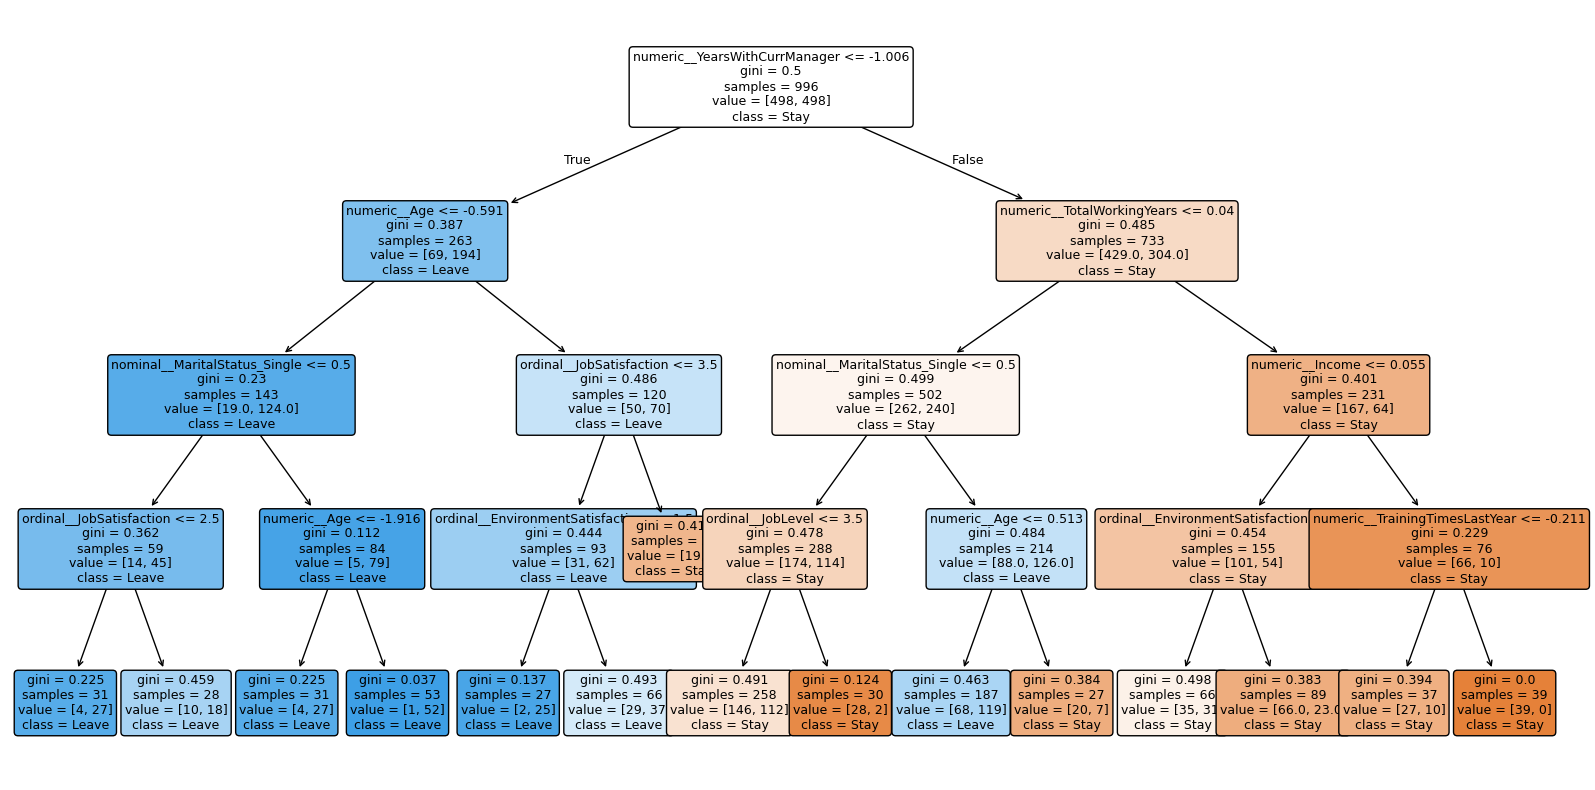

In [63]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
plot_tree(
    dt,
    feature_names=feature_names,
    class_names=["Stay", "Leave"],
    filled=True,
    rounded=True,
    fontsize=9
)
plt.show()


#### Seven Predictors were selected for the decision tree

In [66]:
selected_cols = [
    'NumCompaniesWorked',
    'TotalWorkingYears',
    'EnvironmentSatisfaction',
    'JobSatisfaction',
    'BusinessTravel_Travel_Frequently',
    'MaritalStatus_Single',
    'Age_simple_lab'
]

In [68]:
selected_features = [
    'numeric__NumCompaniesWorked',
    'numeric__TotalWorkingYears',
    'ordinal__EnvironmentSatisfaction',
    'ordinal__JobSatisfaction',
    'nominal__BusinessTravel_Travel_Frequently',
    'nominal__MaritalStatus_Single',
    'numeric__Age'   # Age_simple_lab maps to Age
]

In [69]:
X_train_dt = X_train_processed_balanced_df[selected_features]
X_test_dt  = X_test_processed_df[selected_features]

In [70]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(
    max_depth=4,
    min_samples_leaf=25,
    random_state=random_seed
)

dt.fit(X_train_dt, y_train_balanced)


DecisionTreeClassifier(max_depth=4, min_samples_leaf=25, random_state=172193)

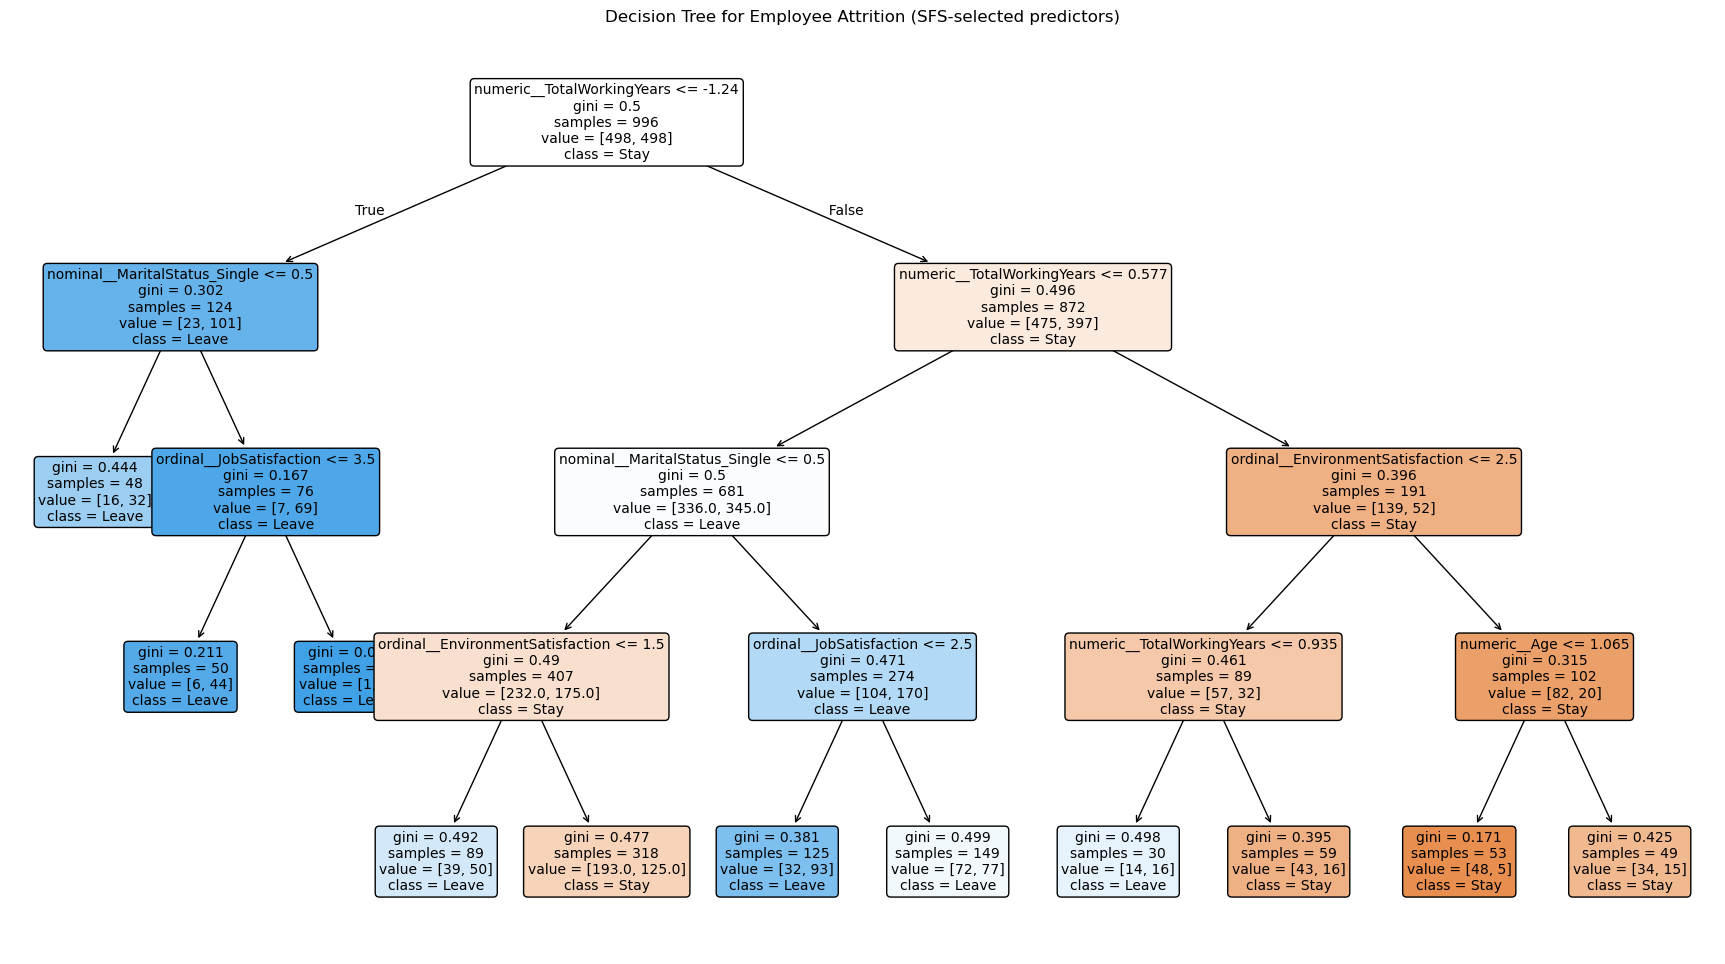

In [71]:
#Plot the tree

plt.figure(figsize=(22, 12))
plot_tree(
    dt,
    feature_names=selected_features,
    class_names=["Stay", "Leave"],
    filled=True,
    rounded=True,
    fontsize=10
)
plt.title("Decision Tree for Employee Attrition (SFS-selected predictors)")
plt.show()
